# Fast Point in Polygon Testing Method
---------------- 
**Author: Hu Shao <shaohutiger@gmail.com>**

## Content
* [Introduction](#Introduction)  
* [How to Use](#How-to-Use)  
* [The process of building quadtree](#The-process-of-building-quadtree)  
* [Visualizing the result of "Point in Polygon" test](#Visualizing-the-result-of-"Point-in-Polygon"-test)
* [Test the performance of this quad-tree-structure](#Test-the-performance-of-this-quad-tree-structure)
* [Validate the correctness of this quad-tree-structure](#Validate-the-correctness-of-this-quad-tree-structure)
* [Algorithm of building quadtree cells for study area](#Algorithm-of-building-quadtree-cells-for-study-area)
* [Reference](#Reference)

## Introduction
Testing whether a point locates inside a polygon is a time consuming work. Especially when the point number is huge and the boundary of study area is complex.  
Here we implement a "Fast Point in Polygon Testing Method" to help users determine whether a point is inside a specific polygon rapidly.  

The Quadtree structure is employed to divide a polygon into plenty of lattices. During the dividing, each lattices is marked as **in**, **out** or **maybe**, which means "totally lies inside the polygon", "totally lies out side the polygon" and "intersect with the boundary if the polygon".   
For each point, we firstly allocate it into a lattice. If the lattice is marked as "in" or "out", we will immediately know the result; if the lattice is marked as "maybe", we then need to do some further calculation, which won't be complex.  
Once the quadtree structure is constructed, the "point in polygon testing" will be very fast.

This method is suitable for the situations where point numbers are huge, polygon numbers are small and polygon boundary is complex. E.g., simulation in point pattern analysis.

In [1]:
# Import essential libraries for following calculation
import sys
path_base_dell = 'C:/work/ASUWork/pysal'
path_base_lenovo = 'D:/ASUWork/pysal'
path_base_os = '/Users/hushao/Documents/ASUWork/pysal_hu/'
# sys.path.append(path_base_dell)
# sys.path.append(path_base_lenovo)
sys.path.append(path_base_os)
import pysal as ps
import numpy as np
from pysal.cg.shapes import Ring, Polygon
from pysal.cg.segmentLocator import BruteSegmentLocator
from pysal.cg.polygonQuadTreeStructure import QuadTreeStructureSingleRing
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import time
# import codecs
# import shapely
# from pysal.cg.shapes import Polygon, Point
# from shapely.geometry import Polygon as spPolygon
# from shapely.geometry import Point as spPoint
# import time
import random
print("import finished!")

import finished!


## How to Use

In [2]:
polygons = ps.open(ps.examples.get_path("us48.shp")) # read in state shape file
study_area = polygons[0] # select one polygon as the study area
# construct the quadtree structure by explicitly calling the function "build_quad_tree_structure" in polygon
study_area.build_quad_tree_structure()
print "quad tree build finished"
# create some random point and test if these points locate in the polygon
for i in range(0, 10):
    x = random.uniform(study_area.bbox[0], study_area.bbox[2])
    y = random.uniform(study_area.bbox[1], study_area.bbox[3])
    print(x, y, study_area.contains_point([x, y]))

quad tree build finished
(-117.31829185914513, 46.920860948999646, True)
(-123.25945438151723, 48.380001726301415, False)
(-122.02926961739914, 48.850156702752635, True)
(-122.55239610098828, 48.518712198888664, False)
(-124.03147681237722, 48.962889174365735, False)
(-124.40105285994518, 45.80064001147677, False)
(-122.72653676225865, 48.1722770617159, False)
(-117.90099866013266, 47.63575806982629, True)
(-120.80463309481338, 48.35855439135854, True)
(-117.21545900969673, 48.23007743240744, True)


## The process of building quadtree
### Data preparing

In [4]:
# data prapering
polygons = ps.open(ps.examples.get_path("us48.shp")) # read in state shape file
fields = ps.open(ps.examples.get_path("us48.dbf"), "r") # read in attributes
print(fields.header)
# find the region of Texas in the dataset
texas = None
for i in xrange(0, len(polygons)):
    if fields[i][0][4].find("Texas") >= 0:
        texas = polygons[i]

polygons = ps.open(ps.examples.get_path("NAT.shp")) # read in county shape file
fields = ps.open(ps.examples.get_path("NAT.dbf"), "r") # read in attributes
print(fields.header)
pecos = None
san_saba = None
# find two counties "Pecos" and "San Saba" inside of Texas. These counties will be used as holes for testing later
for i in xrange(0, len(polygons)):
    if fields[i][0][0].find("Pecos") >= 0:
        pecos = polygons[i]
    if fields[i][0][0].find("San Saba") >= 0:
        san_saba = polygons[i]

[u'AREA', u'PERIMETER', u'STATE_', u'STATE_ID', u'STATE_NAME', u'STATE_FIPS', u'SUB_REGION', u'STATE_ABBR']
[u'NAME', u'STATE_NAME', u'STATE_FIPS', u'CNTY_FIPS', u'FIPS', u'STFIPS', u'COFIPS', u'FIPSNO', u'SOUTH', u'HR60', u'HR70', u'HR80', u'HR90', u'HC60', u'HC70', u'HC80', u'HC90', u'PO60', u'PO70', u'PO80', u'PO90', u'RD60', u'RD70', u'RD80', u'RD90', u'PS60', u'PS70', u'PS80', u'PS90', u'UE60', u'UE70', u'UE80', u'UE90', u'DV60', u'DV70', u'DV80', u'DV90', u'MA60', u'MA70', u'MA80', u'MA90', u'POL60', u'POL70', u'POL80', u'POL90', u'DNL60', u'DNL70', u'DNL80', u'DNL90', u'MFIL59', u'MFIL69', u'MFIL79', u'MFIL89', u'FP59', u'FP69', u'FP79', u'FP89', u'BLK60', u'BLK70', u'BLK80', u'BLK90', u'GI59', u'GI69', u'GI79', u'GI89', u'FH60', u'FH70', u'FH80', u'FH90']


### Quadtree building process - step by step

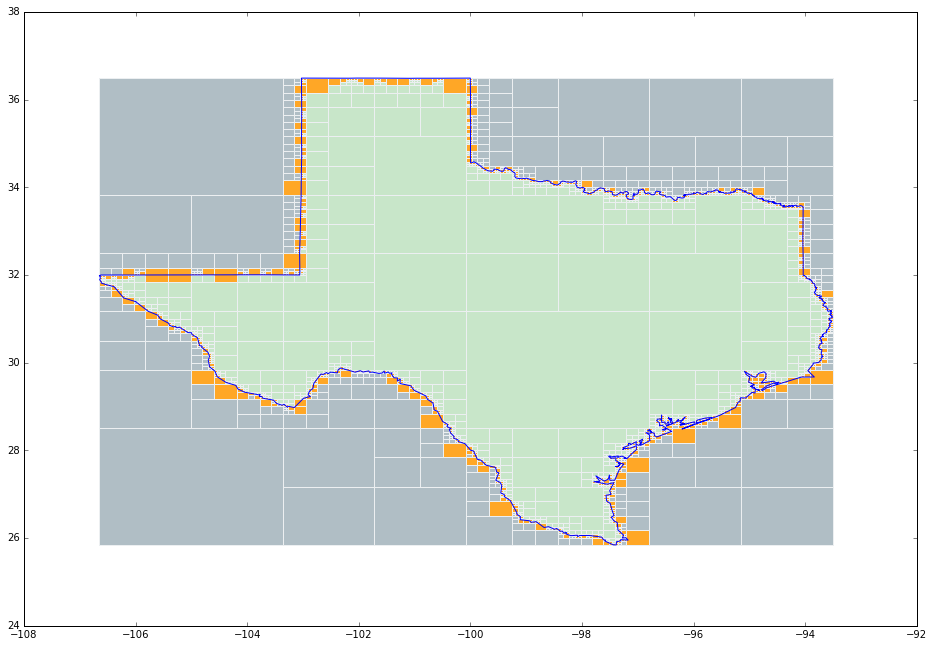

In [23]:
# The region of Texas, to make the steps more clear, here we only use the main region
texas_main_vertices = texas.parts[0]
fig, ax = plt.subplots(figsize=(16,11))
qts_singlering = QuadTreeStructureSingleRing(Ring(texas_main_vertices))
patches = []
color_array = []
cells_to_draw = [qts_singlering.root_cell]
while len(cells_to_draw) > 0:
    cell = cells_to_draw.pop()
        
    if cell.children_l_b is None:
        # this is a leaf in the quad tree structure, draw it
        verts = [
            [cell.min_x, cell.min_y],
            [cell.min_x, cell.min_y + cell.length_y],
            [cell.min_x + cell.length_x, cell.min_y + cell.length_y],
            [cell.min_x + cell.length_x, cell.min_y],
            [cell.min_x, cell.min_y]
                ]
        patches.append(verts)
        if cell.status == "in":
            color_array.append("#c8e6c9")  # in color green
        elif cell.status == "out":
            color_array.append("#b0bec5")  # in color grey
        else:  # means "maybe"
            color_array.append("#ffa726")  # in color orange
    else:
        cells_to_draw.append(cell.children_l_b)
        cells_to_draw.append(cell.children_l_t)
        cells_to_draw.append(cell.children_r_b)
        cells_to_draw.append(cell.children_r_t)
coll = matplotlib.collections.PolyCollection(np.array(patches), facecolors=color_array, edgecolors='#eceff1')
ax.add_collection(coll)
point_x_list = []
point_y_list = []
for point in texas_main_vertices:
    point_x_list.append(point[0])
    point_y_list.append(point[1])    
plt.plot(point_x_list, point_y_list)
ax.autoscale_view()
plt.show()


# Want to see the details of the quad-tree-structure? 
# Use the function below to store the quad-tree cells into a shapefile
# In order to use this funcion, the library [pyshp](https://github.com/GeospatialPython/pyshp) needs to be installed.

# # --------------------------------------------------------------
# import shapefile

# def writeQuadTreeToShapeFile(qts_singlering):
#     w = shapefile.Writer(shapefile.POLYGON)
#     w.autoBalance = 1
#     w.field('status','C','16')
#     cells_to_record = [qts_singlering.root_cell]
#     while len(cells_to_record) > 0:
#         cell = cells_to_record.pop()

#         if cell.children_l_b is None:
#             # this is a leaf in the quad tree structure, record it
#             part = [[
#                 [cell.min_x, cell.min_y],
#                 [cell.min_x, cell.min_y + cell.length_y],
#                 [cell.min_x + cell.length_x, cell.min_y + cell.length_y],
#                 [cell.min_x + cell.length_x, cell.min_y],
#                 [cell.min_x, cell.min_y]
#                     ]]
#             w.poly(parts=part)
#             w.record(cell.status)
#         else:
#             cells_to_record.append(cell.children_l_b)
#             cells_to_record.append(cell.children_l_t)
#             cells_to_record.append(cell.children_r_b)
#             cells_to_record.append(cell.children_r_t)
#     w.save('shapefile/quad_tree')
#     print "Shape file save finished."


# writeQuadTreeToShapeFile(qts_singlering)
# # --------------------------------------------------------------

## Visualizing the result of "Point in Polygon" test

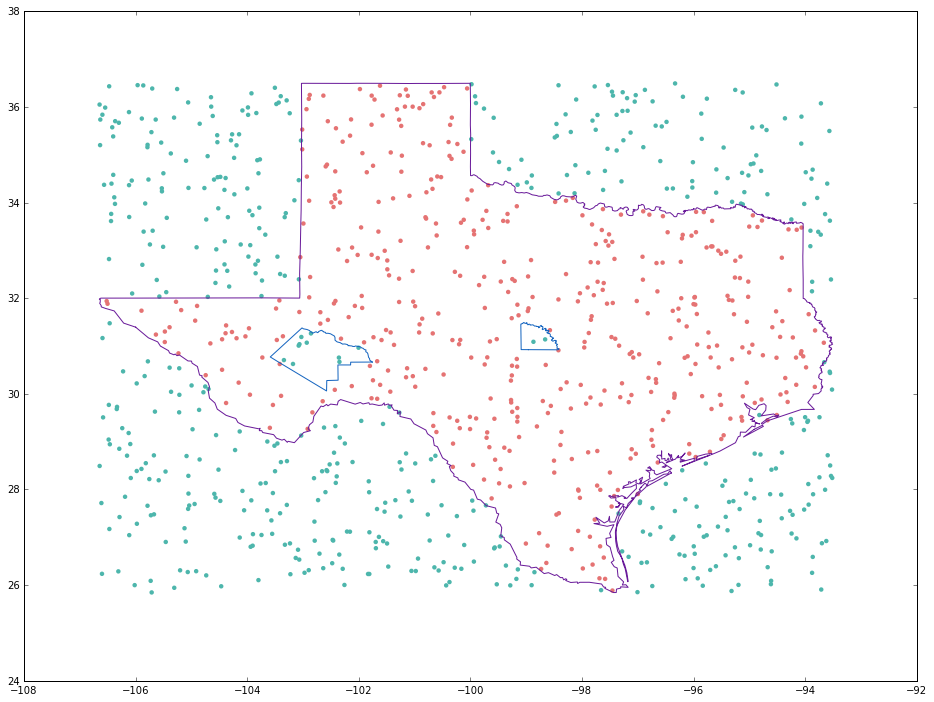

In [5]:
# Construct a new study area, treat the two counties: Pecos and San Saba as holes of Texas for testing
study_area = ps.cg.shapes.Polygon(texas.parts, holes=[pecos.vertices, san_saba.vertices]) 
study_area.build_quad_tree_structure() # construct the quad tree
plt.figure(figsize=(16,12))

for vertices in study_area.parts:
    line_x_list = []
    line_y_list = []
    for point in vertices:
        line_x_list.append(point[0])
        line_y_list.append(point[1])   
    plt.plot(line_x_list, line_y_list, c="#6a1b9a")
for vertices in study_area.holes:
    line_x_list = []
    line_y_list = []
    for point in vertices:
        line_x_list.append(point[0])
        line_y_list.append(point[1])   
    plt.plot(line_x_list, line_y_list, c="#1565c0")
    
point_x_list = []
point_y_list = []
point_colors = []
bbox = study_area.bbox
for i in range(0, 1000):
    x = random.uniform(bbox[0], bbox[2])  
    y = random.uniform(bbox[1], bbox[3])
    point_x_list.append(x)
    point_y_list.append(y) 
    if study_area.contains_point([x, y]):
        point_colors.append("#e57373") # inside, red 
    else:
        point_colors.append("#4db6ac") # outside, green

plt.scatter(point_x_list, point_y_list, c = point_colors, linewidth = 0)
plt.show()

### Test the performance of this quad-tree-structure

In [15]:
# polygons = ps.open("data/Huangshan_region.shp")  # read the research region shape file
# research_region = polygons[0]  # set the first polygon as research polygon
# len(research_region.vertices)
vertices = []
file = open("data/study_region_huangshan_point.txt", "r")
for line in file:
    if len(line)<2:
        continue
    coordinates = line.split(",")
    x = (float)(coordinates[0])
    y = (float)(coordinates[1])
    vertices.append((x, y))
file.close()
print "Study region read finished, with vertices of " + str(len(vertices))
huangshan = Ring(vertices)

points = []
bbox = huangshan.bounding_box
for i in range(0, 10000):
    x = random.uniform(bbox[0], bbox[2])  
    y = random.uniform(bbox[1], bbox[3])
    points.append((x, y))    
    
print str(len(points)) + " random points generated"    

print "------------------------------"
print "Begin test without quad-tree-structure"
time_begin = int(round(time.time() * 1000))
for point in points:
    huangshan.contains_point(point)
time_end = int(round(time.time() * 1000))
print "Test without quad-tree-structure finished, time used = " + str((time_end-time_begin)/1000.0) + "s"

print "------------------------------"
print "Begin test with quad-tree-structure"
time_begin = int(round(time.time() * 1000))
huangshan.build_quad_tree_structure()
count_error = 0
for point in points:
    huangshan.contains_point(point)
time_end = int(round(time.time() * 1000))
print "Test with quad-tree-structure finished, time used = " + str((time_end-time_begin)/1000.0) + "s"

Study region read finished, with vertices of 3891
10000 random points generated
------------------------------
Begin test without quad-tree-structure
Test without quad-tree-structure finished, time used = 87.576s
------------------------------
Begin test with quad-tree-structure
Test with quad-tree-structure finished, time used = 1.207s


### Validate the correctness of this quad-tree-structure

In [14]:
# polygons = ps.open("data/Huangshan_region.shp")  # read the research region shape file
# research_region = polygons[0]  # set the first polygon as research polygon
# len(research_region.vertices)
vertices = []
file = open("data/study_region_huangshan_point.txt", "r")
for line in file:
    if len(line)<2:
        continue
    coordinates = line.split(",")
    x = (float)(coordinates[0])
    y = (float)(coordinates[1])
    vertices.append((x, y))
file.close()
print "Study region read finished, with vertices of " + str(len(vertices))

huangshan = Ring(vertices)

points = []
bbox = huangshan.bounding_box
for i in range(0, 1000):
    x = random.uniform(bbox[0], bbox[2])  
    y = random.uniform(bbox[1], bbox[3])
    points.append([x, y, True])    
print str(len(points)) + " random points generated"    

# First, test if these points are inside of the polygon by the conventional method, record the result
for point in points:
    is_in = huangshan.contains_point((point[0], point[1]))
    point[2] = is_in

# Then, build the quad-tree and do the test again. Compare the results of two methods.
count_error = 0
huangshan.build_quad_tree_structure()  
for point in points:
    is_in = huangshan.contains_point((point[0], point[1]))
    if point[2] != is_in:
        print "Error found!!!"
        count_error += 1

    
if count_error == 0:
    print "finished ==================== no error found"
else:
    print "finished ===================="

Study region read finished, with vertices of 3891
1000 random points generated
finished ==================== no error found


## Algorithm for building quadtree cells for study area
A huge number of points will be simulated and test if falls in the study area in the real case. This calculation process is very computing intensive. Especially when the boundary of study area is complex and contains a lot of segments, or the simulation time is also large.   
In order to fast decide whether a point is contained in the study area, we can prepare an grid structure which divide the study area into quadtree based regular rectangles. Each rectangles will have a specific status from ['in', 'out', 'maybe']. After we prepared this kind of grid structure, deciding whether a points falls in the study area will be very easy: first, allocate the point into a specific cell. For the cell with different status:  
- in: the point must be in the study area  
- out: the point must not be in the study area  
- maybe: decide if the points falls into the study area by some following-up calculation. However, the small polygon contains much less boundary segments, the calculation will be much easier. What's more, this kind of grids only take over a very small part of the whole grids  
![quadtree_example](img/quadtree_example.png)

### Process of duadtree dividing of the study area:
Treat the boundary of the study area as arc. Each time of dividing the study area means use two straight lines (on horizontal and one vertical) to split a big rectangle (cell) into 4 smaller ones. During this process, the arc should also be used to intersect with the straight lines and break into small segments. Different segments should belong to different cells and can be used to determine the status of the cell (as we mentioned: in, out or maybe inside of the study area.) Repeat this process until the cell's size is small enough.  
During the dividing, there are <font style="color:blue">some special properties of the arcs</font> we need to know:  
- Point order of the arcs **MUST** be clockwise  
- The two end-points of each arc **MUST** lie on the borders of the cell  
- When a arc goes in a cell, it **MUST** goes out from the same one  
- The intersection points **MUST** be lying on the inner-boundaries which are used to divide the cell into 4 sub-cells
- Use the intersection points to split the arcs into small ones  
- No need to store cell boundaries as arcs, store the intersection points, points' relative location from  


The following image depicts the categorize rule of cell boundary when being divided into sub cells:  
<b style="color:blue">cell_boundary_category_rule</b>  
![cell_boundary_category_rule](img/cell_boundary_category_rule.png)

<b style="color:blue">segment_sequence_search_rule</b>  
![segment_sequence_search_rule](img/segment_sequence_search_rule.png)

In the situations that there are some arcs intersect with a cell and we need to extract the segment squence, here is the rule:  
1. Start on the bottom-left point of the cell, go clockwise to search points.  
2. Find the first arc-begin-point on the cell's border. The actual segment sequence begin from here.  
3. Go alone the arc until the end point on the border. Then go alone the cell's border until find next arc-begin-point.  
4. Repeat **Step.3** until reach the first arc-begin-point at **Step.2**. Search stop.

From the image we can see that the red border lines also belong to the segment sequence.  
During the quadtree dividing, when there is a cell who doesn't intersect with any arc, we need to determine whether this cell is totally within the study area or not. we Can use the method above to determine: If this cell share a border which belongs to other cells' segment sequence, then this cell is totally within the study area; vice versa


<b style="color:blue">extract_connecting_boders_between_points</b>  
![extract_connecting_boders_between_points](img/extract_connecting_boders_between_points.png)

<b style="color:blue">situation_segment_intersect_with_two_split_line</b>
![situation_segment_intersect_with_two_split_line](img/situation_segment_intersect_with_two_split_line.png)

Under the sitiation that a single segment intersects with both split-lines. This kind of situation should be carefully treated.


## Reference
Point in Polygon Strategies http://erich.realtimerendering.com/ptinpoly/  
Samet, Hanan. Foundations of multidimensional and metric data structures. Morgan Kaufmann, 2006.  
Jiménez, Juan J., Francisco R. Feito, and Rafael J. Segura. "A new hierarchical triangle-based point-in-polygon data structure." Computers & Geosciences 35, no. 9 (2009): 1843-1853.  
http://stackoverflow.com/questions/12881848/draw-polygons-more-efficiently-with-matplotlib  
http://matplotlib.org/api/collections_api.html  
http://materializecss.com/color.html 